Epoch 1/100


/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7735/7735 ━━━━━━━━━━━━━━━━━━━━ 130s 17ms/step - loss: 0.0025 - mae: 0.0337 - val_loss: 0.0027 - val_mae: 0.0385
Epoch 2/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 130s 17ms/step - loss: 2.6309e-04 - mae: 0.0116 - val_loss: 0.0018 - val_mae: 0.0332
Epoch 3/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 139s 18ms/step - loss: 1.6719e-04 - mae: 0.0091 - val_loss: 0.0023 - val_mae: 0.0357
Epoch 4/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 125s 16ms/step - loss: 1.4364e-04 - mae: 0.0082 - val_loss: 0.0027 - val_mae: 0.0402
Epoch 5/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 128s 17ms/step - loss: 1.2751e-04 - mae: 0.0076 - val_loss: 0.0026 - val_mae: 0.0380
Epoch 6/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 134s 17ms/step - loss: 1.1898e-04 - mae: 0.0071 - val_loss: 0.0026 - val_mae: 0.0385
Epoch 7/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 143s 18ms/step - loss: 1.1699e-04 - mae: 0.0070 - val_loss: 0.0021 - val_mae: 0.0350
Epoch 8/100
7735/7735 ━━━━━━━━━━━━━━━━━━━━ 139s 18ms/step - loss: 1.0093e-04 - mae: 0.0066 - val_loss: 0.0022 - val_mae:

Test Loss: 0.00263101514428854, Test MAE: 0.03958546742796898
1934/1934 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step


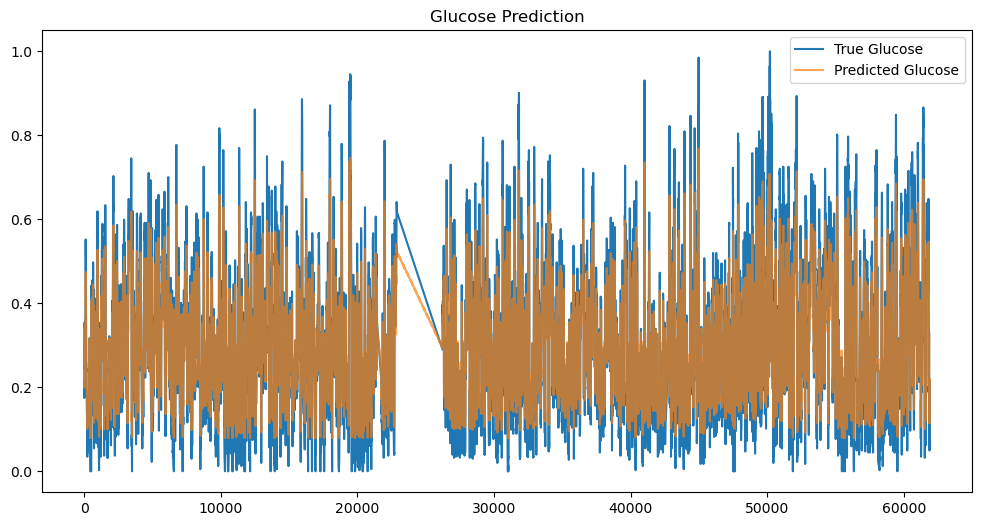

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/sg/f70605tj49gf5qq225kwnddh0000gn/T/ipykernel_4657/1192263430.py", line 101, in <module>
    predictions.to_csv('glucose_predictions.csv', index=False)
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    raise TypeError(msg)
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/pandas/core/generic.py", line 3720, in to_csv
    str or None
           ^^^^
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/pandas/util/_decorators.py", line 211, in wrapper
    raise TypeError(msg)
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/pandas/io/formats/format.py", line 1162, in to_csv
  File "/Users/zinaghottis/anaconda3/lib/python3.11/site-packages/panda

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to dataset
dataset_path = "/Users/zinaghottis/Downloads/HUPA-UCM Diabetes Dataset/Preprocessed"

# 1. Load and Merge Data
def load_and_merge_data(directory):
    all_data = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            file_path = os.path.join(directory, file)
            data = pd.read_csv(file_path, delimiter=';')
            data['time'] = pd.to_datetime(data['time'], errors='coerce')
            all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

# Load the dataset
data = load_and_merge_data(dataset_path)

# 2. Feature Engineering
# Glucose Rate of Change
data['glucose_rate_of_change'] = data['glucose'].diff() / (data['time'].diff().dt.total_seconds() / 60)

# Insulin-Carb Ratio
data['insulin_carb_ratio'] = data['bolus_volume_delivered'] / (data['carb_input'] + 1e-6)

# Activity Intensity
data['activity_intensity'] = data['heart_rate'] * data['steps']

# Remove rows with NaN values
data.dropna(inplace=True)

# 3. Normalize Features
scaler = MinMaxScaler()
feature_columns = ['glucose', 'glucose_rate_of_change', 'insulin_carb_ratio', 'activity_intensity', 'calories', 'basal_rate']
data[feature_columns] = scaler.fit_transform(data[feature_columns])

# 4. Prepare Sequences for LSTM

def create_sequences(data, target_column, seq_length=20):
    X, y = [], []
    data = data.reset_index(drop=True)
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][feature_columns].values)
        y.append(data.iloc[i+seq_length][target_column])
    return np.array(X), np.array(y)

X, y = create_sequences(data, target_column='glucose')

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# 6. Define the LSTM Model

model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.3),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 7. Train the Model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# 8. Evaluate the Model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# 9. Save the Model
model.save('complex_lstm_glucose_model.h5')

# 10. Predict and Plot Results
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Glucose')
plt.plot(y_pred, label='Predicted Glucose', alpha=0.7)
plt.legend()
plt.title('Glucose Prediction')
plt.show()

# Optional: Save predictions
predictions = pd.DataFrame({'True Glucose': y_test, 'Predicted Glucose': y_pred.flatten()})
predictions.to_csv('glucose_predictions.csv', index=False)


In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


Mean Absolute Error (MAE): 0.039585497395385756
Root Mean Squared Error (RMSE): 0.05129341482053071
R² Score: 0.9147740289804451


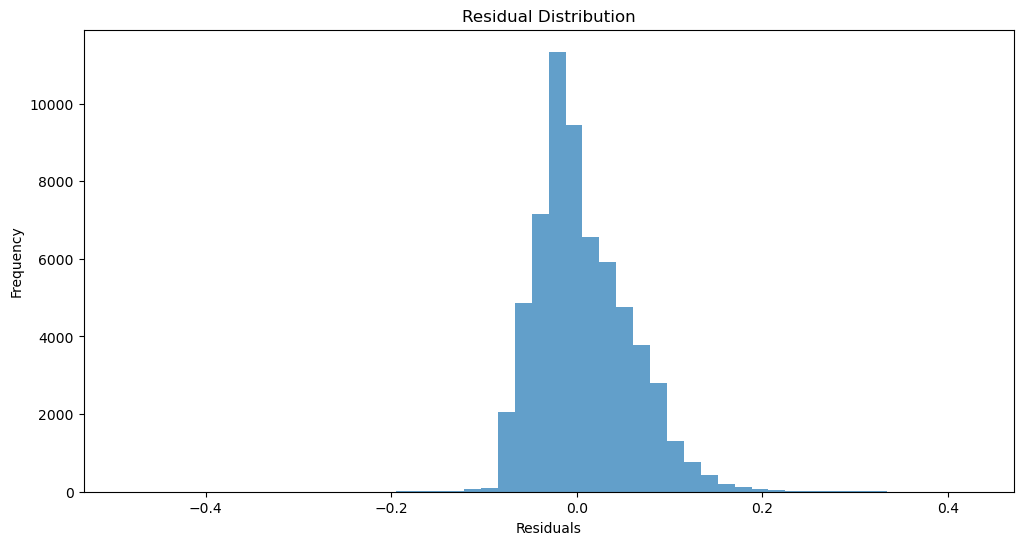

In [3]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Plot residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Define thresholds
hypo_threshold = 0.1  # Adjust based on normalized data
hyper_threshold = 0.9

# Calculate true positives, false positives, etc.
y_test_hypo = y_test < hypo_threshold
y_pred_hypo = y_pred.flatten() < hypo_threshold

y_test_hyper = y_test > hyper_threshold
y_pred_hyper = y_pred.flatten() > hyper_threshold

# Hypoglycemia metrics
hypo_accuracy = np.mean(y_test_hypo == y_pred_hypo)
print(f"Hypoglycemia Accuracy: {hypo_accuracy}")

# Hyperglycemia metrics
hyper_accuracy = np.mean(y_test_hyper == y_pred_hyper)
print(f"Hyperglycemia Accuracy: {hyper_accuracy}")


Hypoglycemia Accuracy: 0.9112727272727272
Hyperglycemia Accuracy: 0.999030303030303


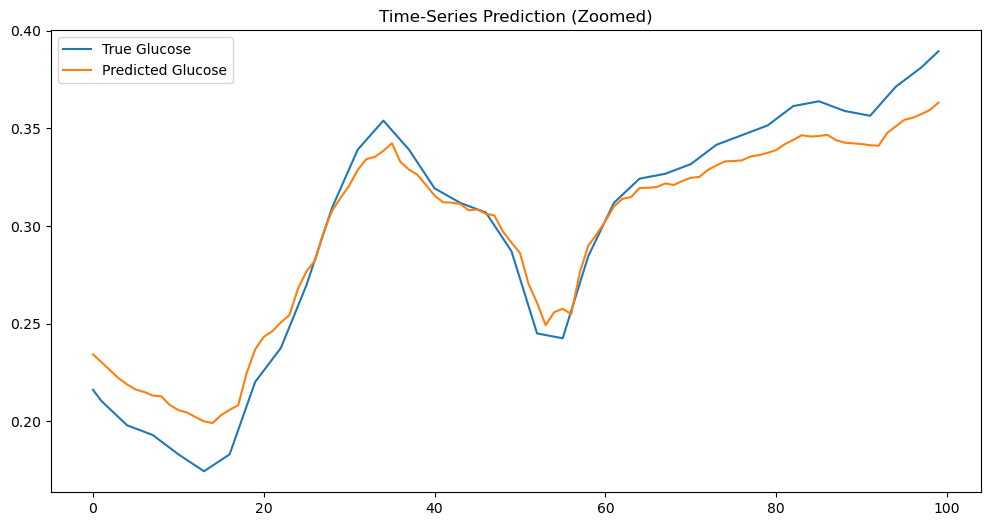

In [5]:
# Plot a smaller window of predictions
window = 100  # Adjust to desired length
plt.figure(figsize=(12, 6))
plt.plot(y_test[:window], label="True Glucose")
plt.plot(y_pred[:window], label="Predicted Glucose")
plt.legend()
plt.title("Time-Series Prediction (Zoomed)")
plt.show()

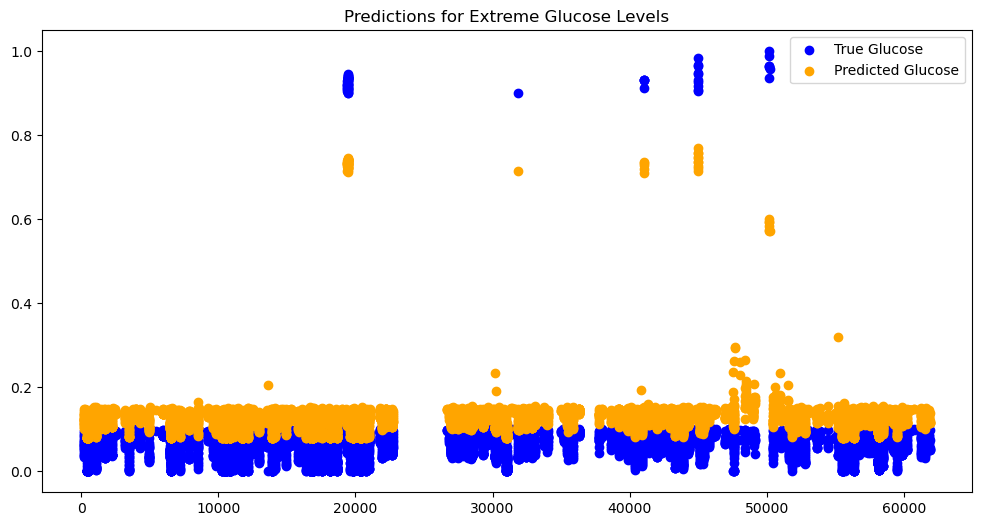

In [8]:
# Identify extreme values
extreme_indices = np.where((y_test < hypo_threshold) | (y_test > hyper_threshold))[0]

# Plot predictions for extreme values
plt.figure(figsize=(12, 6))
plt.scatter(extreme_indices, y_test[extreme_indices], label="True Glucose", color="blue")
plt.scatter(extreme_indices, y_pred.flatten()[extreme_indices], label="Predicted Glucose", color="orange")
plt.legend()
plt.title("Predictions for Extreme Glucose Levels")
plt.show()


In [ ]:
predictions = pd.DataFrame({
    "True Glucose": y_test,
    "Predicted Glucose": y_pred.flatten()
})
predictions.to_csv("model_predictions.csv", index=False)
